Zaganjam Grid Search za vse modele...

Model: Ridge
Model: DecisionTree
Model: RandomForest
Model: GradientBoosting
Model: KNN

=== Rezultati po GridSearchCV (na testni množici) ===


,Model,Najboljši parametri,R² (test),RMSE (test),MAE (test),R² (CV mean ± SD)
0,Ridge,{'alpha': 1},0.665,14.528,11.521,0.631 ± 0.020
1,DecisionTree,"{'max_depth': 6, 'min_samples_leaf': 8, 'min_s...",0.628,15.308,12.080,0.595 ± 0.018
2,RandomForest,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.666,14.510,11.553,0.634 ± 0.021
3,GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.678,14.246,11.272,0.639 ± 0.021
4,KNN,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",0.613,15.613,12.178,0.585 ± 0.025


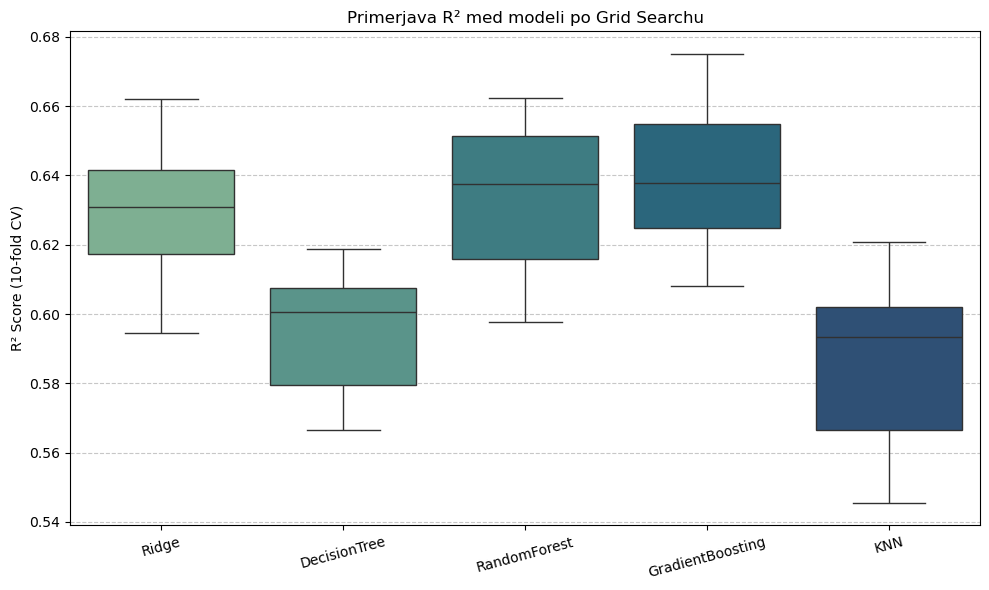


Modeli shranjeni kot .pkl datoteke v trenutni direktorij.


In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold, train_test_split,  cross_val_score
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === PRIPRAVA PODATKOV ===

df = pd.read_csv("../Telco-Customer-Churn-Cleaned.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges', 'tenure'])

df_model = df.copy()

# Odstranimo nepotrebne stolpce
drop_cols = ["customerID", "TotalCharges"]  # TotalCharges je skoraj linearno odvisen od tenure
df_model = df_model.drop(columns=[c for c in drop_cols if c in df_model.columns])

# Oznacimo target
y = df_model["tenure"]
X = df_model.drop(columns=["tenure"])

# Pretvorimo kategorije v številske vrednosti (One-Hot Encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

selected_features = [
    "Contract_Two year", 
    "Contract_One year", 
    "MonthlyCharges", 
    "MultipleLines_Yes", 
    "Partner_Yes", 
    "OnlineBackup_Yes", 
    "PaymentMethod_Mailed check", 
    "Churn_Yes", 
    "OnlineSecurity_Yes", 
    "DeviceProtection_Yes",
    "PaymentMethod_Electronic check"
]

X_final = X_encoded[selected_features]
y_final = df["tenure"]

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42
)

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# === DEFINICIJA MODEL + SEARCH SPACE ===

grid_spaces = {
    "Ridge": {
        "model": Ridge(),
        "params": {"alpha": [0.01, 0.1, 1, 5, 10, 20]}
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [4, 6, 8, 10, 12],
            "min_samples_split": [2, 5, 10, 20],
            "min_samples_leaf": [1, 2, 4, 8]
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [6, 10, 14, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["sqrt", "log2"]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 4, 5, 6],
            "subsample": [0.7, 0.9, 1.0]
        }
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            "n_neighbors": [3, 5, 7, 10, 15],
            "weights": ["uniform", "distance"],
            "metric": ["minkowski", "manhattan"]
        }
    }
}

# === GRID SEARCH + SHRANJEVANJE ===

results = []
fold_results = {}  # za boxplot grafe

print("Zaganjam Grid Search za vse modele...\n")
for name, config in grid_spaces.items():
    print(f"Model: {name}")
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        scoring="r2",
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    joblib.dump(best_model, f"best_model_{name}.pkl")  # shrani model
    
    # Oceni na testnih podatkih
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Shranimo rezultate (mean ± SD iz 5-fold cross-val)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring="r2")
    fold_results[name] = cv_scores
    
    results.append({
        "Model": name,
        "Najboljši parametri": best_params,
        "R² (test)": round(r2, 3),
        "RMSE (test)": round(rmse, 3),
        "MAE (test)": round(mae, 3),
        "R² (CV mean ± SD)": f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}"
    })

results_df = pd.DataFrame(results)
print("\n=== Rezultati po GridSearchCV (na testni množici) ===")
display(results_df)

# Shranimo tabelo v Excel
results_df.to_csv("optimised_models_results.csv", index=False)

# === BOX PLOT: Primerjava R² po modelih (CV) ===

plt.figure(figsize=(10, 6))
cv_data = [fold_results[m] for m in fold_results.keys()]
model_order = list(fold_results.keys())

sns.boxplot(data=cv_data, palette="crest")
plt.xticks(ticks=range(len(model_order)), labels=model_order, rotation=15)
plt.ylabel("R² Score (10-fold CV)")
plt.title("Primerjava R² med modeli po Grid Searchu")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

print("\nModeli shranjeni kot .pkl datoteke v trenutni direktorij.")

# Primerjava Modelov za Napovedovanje Tenure

| Model | Interpretacija | Povzetek |
|-------|----------------|---------|
| **Gradient Boosting** | R² = 0.678 → model pojasni 68 % variabilnosti tenure. RMSE = 14.25 in MAE = 11.27 → povprečna napaka ≈ 11 mesecev. Najboljši rezultat od vseh. SD (0.021) kaže stabilnost čez folde (ni preučen). |  **Najboljši model** – kompleksna metoda (nelinearne kombinacije atributov). |
| **Random Forest** | R² = 0.666 – skoraj enako dober, RMSE 14.51 in MAE 11.55. V primerjavi z GB ima malenkost večjo napako, a zelo dobre rezultate. |  robusten, a malo "šumnejši". |
| **Ridge Regression** | Linearni model, R² = 0.665 (skoraj enako kot RF!), RMSE = 14.53, MAE = 11.52. Pomeni, da so odnosi med spremenljivkami pretežno linearni. |  **Učinkovit in razložljiv**, skoraj identičen Random Forestu. |
| **Decision Tree** | R² = 0.628 → srednje dober, napaka večja (~15.3 RMSE). Model je preprost, a slabše generalizira. |  **preveč enostaven.** |
| **KNN** | R² = 0.613, RMSE = 15.61 → najslabši rezultat. KNN ni primeren, ker podatki niso "lokalno podobni". |  **Najslabsi model.** |